# Illumina 450k Analysis Pipeline

## Introduction

DNA methylation is a process in which a methyl group (CH<sub>3</sub>) is added to the C-5 position of the cytosine ring of DNA by DNA methyltransferase. CpG islands are stretches of DNA, at least 200 bp long, with a GC content greater than 50% and an observed-to-expected CpG ratio greater than 60%. When methylation occurs inside CpG islands of promoters it causes silencing of gene expression and is, therefore, a very important epigenetic modification. It can be measured as a mean of the methylation status (non-methylated, hemimethylated or methylated) of a population of DNA molecules using methylation arrays.

Infinium HumanMethylation450 BeadChip is a slide composed of 12 arrays that can altogether accomodate 12 samples. With 485 512 probes it covers 99% of RefSeq genes. For each probe sequence, a median of 14 beads, each containing hundreds of thousands of oligonucleotides, is randomly distributed on the array.

Sample preparation includes bisulfite conversion which transforms the unmethylated cytosine to uracil while leaving the methylated cytosine intact. PCR amplification then substitutes uracil with thymine reducing the differentiation between methylated and unmethylated cytosine to a differentiation between cytosine and thymine. Samples are subsequently hybridized to the array and fluorescently labeled nucleotides are added for a single-base extension. The emission of red light indicates the incorporation of A or T, while the emission of green light indicates the incorporation of C or G.

Illumina 450k combines two different assay chemistry technologies. Infinium I uses two types of probes (one for the methylated allele and one for the unmethylated allele) but both signals are measured in the same color (red or green). Infinium II uses a single probe type for both alleles but methylated and unmethylated signals are measured in green and red, respectively.

This report describes a pipeline for the analysis of Illumina 450k DNA methylation data in R using the Bioconductor package [minfi](http://bioconductor.org/packages/release/bioc/html/minfi.html). It includes the following sections:
1. Importing raw data files
2. Quality checks
3. Background correction and normalization
4. Batch effects
5. Differential methylation

## Dependencies

In [1]:
suppressWarnings(suppressMessages(library(minfi)))
suppressWarnings(suppressMessages(library(gap)))
suppressWarnings(suppressMessages(library(gplots)))

These dependencies can be installed from Bioconductor and from a specified CRAN mirror.

In [ ]:
source("https://bioconductor.org/biocLite.R")
biocLite("minfi") 

repos <- 'http://cran.mirror.garr.it/mirrors/CRAN/'
install.packages("gap",repos)
install.packages("gplots",repos)

## 1. Importing raw data files

First, we set the base directory and read the Illumina methylation sample sheet that specifies the layout of the experiment. We then read the .idat files which contain the unprocessed intensity values generated by the Illumina iScan. The raw data is loaded into an RGChannelSet object which stores red and green intensities for each address (probe).

In [2]:
baseDir <- (".")
targets <- read.metharray.sheet(baseDir)
RGset <- read.metharray.exp(targets = targets,extend=T)

[read.metharray.sheet] Found the following CSV files:


[1] "./SampleSheet_report.csv"


The red and green fluorescences are transformed into two data frames for further analysis.

In [3]:
Red <- data.frame(getRed(RGset))
Green <- data.frame(getGreen(RGset))

We can now look at the red and green fluorescences for a specific address, for example **18744490**.

In [4]:
address <- "18744490"
fluorescence <- cbind(t(Red[address,]),t(Green[address,]))
colnames(fluorescence) <- c("Red","Green")
fluorescence

,Red,Green
X9376538140_R01C02,479,289
X9376538140_R03C01,598,476
X9376538140_R03C02,520,513
X9376538140_R06C01,3925,11471
X9403904089_R03C01,3667,12224
X9403904089_R04C02,4262,11662
X9403904089_R05C01,645,542
X9403904089_R06C01,505,493


Next, we create a MethylSet object by converting the red/green channel into methylation signal, without using any normalization.

In [5]:
MSet.raw <- preprocessRaw(RGset)

Loading required package: IlluminaHumanMethylation450kmanifest


## 2. Quality checks

### 2.1. QC plot
Sample-specific quality control information is extracted from the MethylSet object and the log median intensity of the methylated channels is plotted agains that of unmethylated channels. Good samples usually cluster together, while failed samples tend to separate and have lower median intensities. Therefore, the plot below does not show any outlier samples that may be of poor quality.

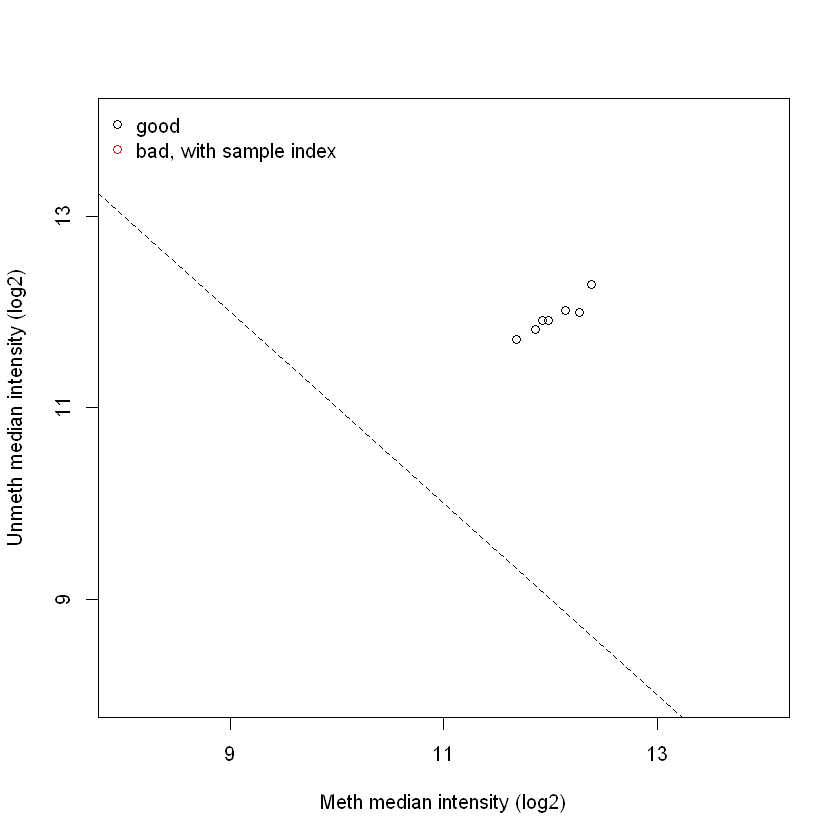

In [6]:
qc <- getQC(MSet.raw)
plotQC(qc)

### 2.2. Negative controls
Illumina 450k contains both sample-independent (not based on the hybridization) and sample-dependent (based on the hybridization) control probes. We plot the negative control probes, which are randomly permutated bisulphite-converted sequences that should not hybridize to DNA. Since these controls are sample-dependent, a dramatic increase in the signal intensity may indicate poor DNA template quality, but this is not our case.

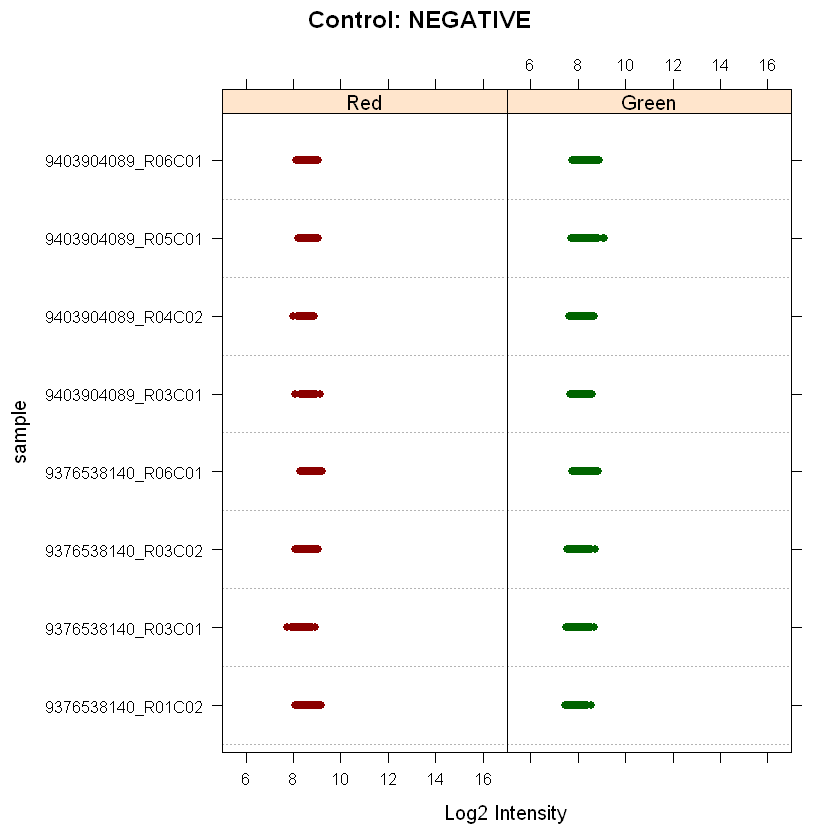

In [7]:
controlStripPlot(RGset, controls="NEGATIVE")

### 2.3. Detection p-value
Detection p-value indicates the chance that the target sequence signal is distinguishable from the negative controls and is an objective measure of overall probe performance. We compute the detection p-value and obtain the positions with nonsignificant p-values (for example above **0.05**). A summary of these positions is provided below. Since they are only few (up to 500 per sample) and, as such, will not affect normalization procedures, we do not filter them out.

In [8]:
detP <- detectionP(RGset)
threshold <- 0.05
failed <- summary(detP>threshold)
failed <- data.frame(failed)
failed <- failed[seq(3,nrow(failed),3),2:3]
rownames(failed) <- c()
colnames(failed) <- c("Sample",paste("Number of probes (detP>",threshold,")",sep=''))
failed

Sample,Number of probes (detP>0.05)
9376538140_R01C02,TRUE :502
9376538140_R03C01,TRUE :412
9376538140_R03C02,TRUE :393
9376538140_R06C01,TRUE :98
9403904089_R03C01,TRUE :121
9403904089_R04C02,TRUE :119
9403904089_R05C01,TRUE :357
9403904089_R06C01,TRUE :441


## 3. Background correction and normalization

### 3.1. Raw data
First, we extract raw beta and M values from the MethylSet object using the appropriate accessor functions. Beta values are the percentage of methylation at a given CpG site ($\beta = \frac{M}{M+U}$), while M values are the log ratio between methylated and unmethylated signals ($M = log_2\frac{M}{U}$). They are both continuous variables, but beta values can vary between 0 (absent methylation) and 1 (completely methylated), while M values can in principle take on any real value.

In [9]:
beta <- getBeta(MSet.raw)
M <- getM(MSet.raw)

We calculate mean beta and mean M values with their respective densities in order to plot them. The mean beta density plot shows two clearly separated peaks corresponding to unmethylated and methylated signals, respectively, while in the mean M density plot the two peaks are not that well separated and are closer together. Boxplots of beta and M values are also generated and show the same pattern of median values between samples.

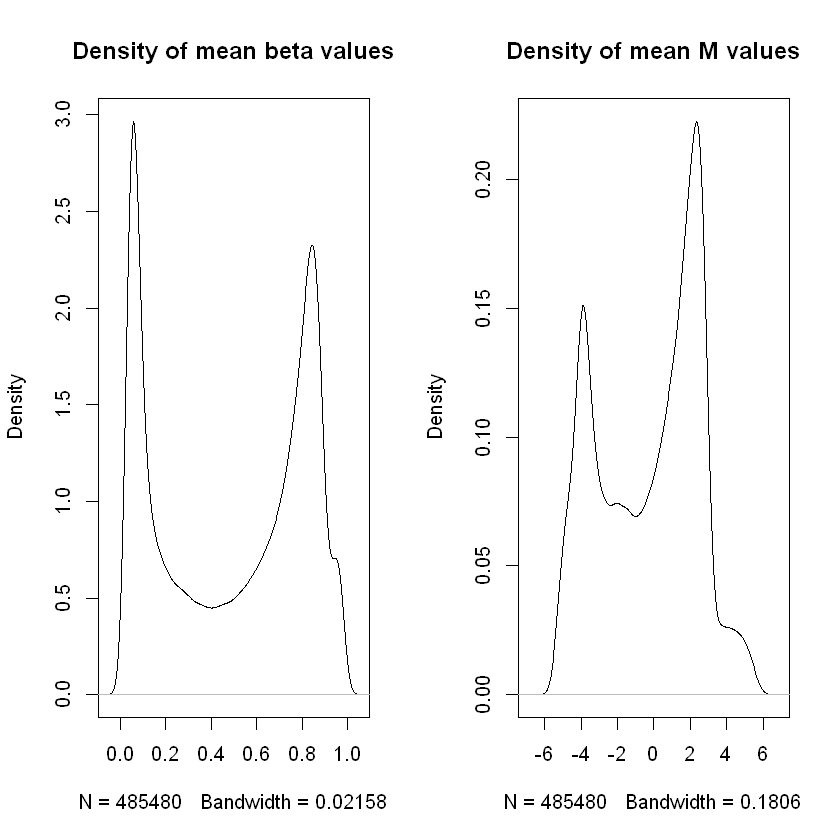

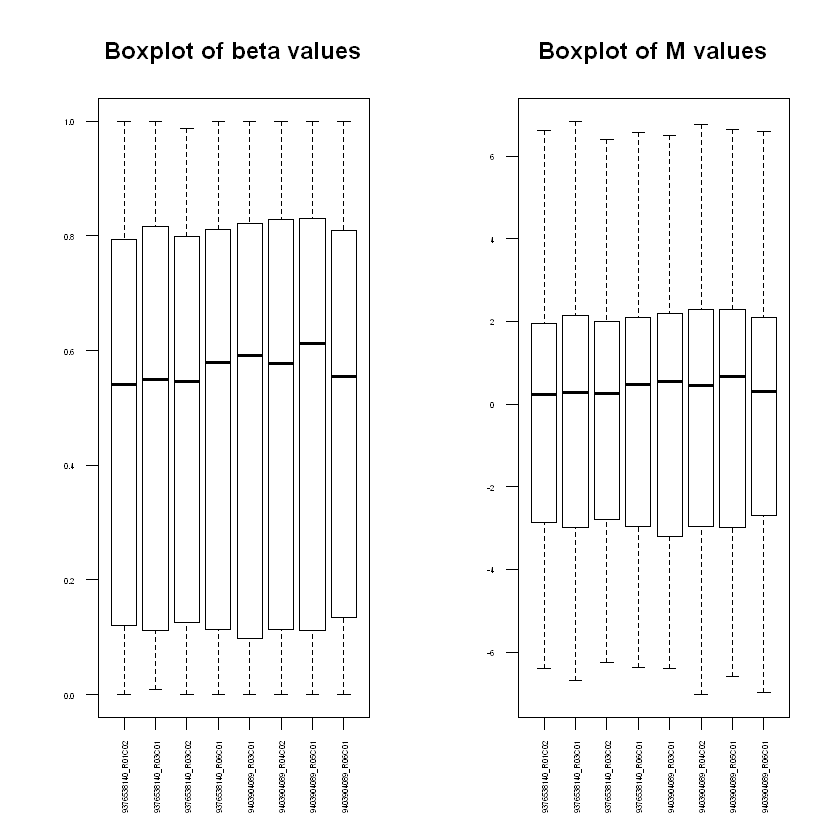

In [10]:
mean_of_beta <- apply(beta,1,mean)
mean_of_M <- apply(M,1,mean)
d_mean_of_beta <- density(mean_of_beta,na.rm=T)
d_mean_of_M <- density(mean_of_M,na.rm=T)

par(mfrow=c(1,2))
plot(d_mean_of_beta,main="Density of mean beta values")
plot(d_mean_of_M,main="Density of mean M values")

options(warn=-1) #turns off the warnings
par(mfrow=c(1,2))
boxplot(beta,las=2,cex.axis=0.4,main="Boxplot of beta values")
boxplot(M,las=2,cex.axis=0.4,main="Boxplot of M values")
options(warn=0) #turns the warnings back on

### 3.2. Functional normalization (Funnorm)
Next, normalization is performed on the RGChannelSet object in order to remove technical variation. Functional normalization (Funnorm) is a between-array normalization method that removes unwanted variation by regressing out variability explained by the control probes present on the array. It includes background and dye bias correction, mapping to genome, quantile extraction and normalization. Normalized beta and M values are extracted as before.

In [11]:
preprocessFunnorm_results <- preprocessFunnorm(RGset)

beta_preprocessFunnorm <- getBeta(preprocessFunnorm_results)
M_preprocessFunnorm <- getM(preprocessFunnorm_results)

[preprocessFunnorm] Background and dye bias correction with noob
Loading required package: IlluminaHumanMethylation450kanno.ilmn12.hg19


[preprocessNoob] Applying R/G ratio flip to fix dye bias...


[preprocessFunnorm] Mapping to genome
[preprocessFunnorm] Quantile extraction
[preprocessFunnorm] Normalization


We calculate the mean and the standard deviation of the normalized beta and M values, plotting them against each other to check for homo/heteroscedasticity (constant/non constant variance). Normalized beta values in the low (&lt;0.2) and high (>0.8) methylation range are significanty heteroscedastic, while normalized M values are slightly less so.

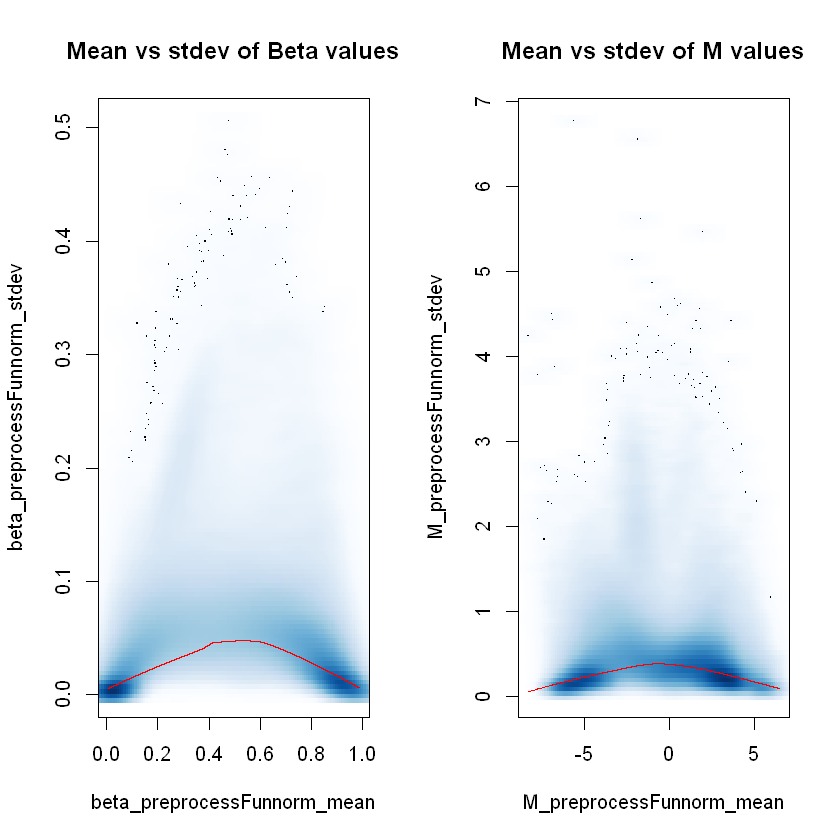

In [12]:
beta_preprocessFunnorm_mean <- apply(beta_preprocessFunnorm, 1, mean)
beta_preprocessFunnorm_stdev <- apply(beta_preprocessFunnorm, 1, sd)
M_preprocessFunnorm_mean <- apply(M_preprocessFunnorm,1, mean)
M_preprocessFunnorm_stdev <- apply(M_preprocessFunnorm,1, sd)

M_preprocessFunnorm_mean <- M_preprocessFunnorm_mean[!M_preprocessFunnorm_mean=="-Inf"] #removes -Inf values for the mean of M
M_preprocessFunnorm_stdev <- M_preprocessFunnorm_stdev[!is.na(M_preprocessFunnorm_stdev)] #removes missing values for the standard deviation of M

par(mfrow=c(1,2))
smoothScatter(beta_preprocessFunnorm_mean, beta_preprocessFunnorm_stdev, main="Mean vs stdev of Beta values")
lines(lowess(beta_preprocessFunnorm_mean, beta_preprocessFunnorm_stdev), col="red")
smoothScatter(M_preprocessFunnorm_mean, M_preprocessFunnorm_stdev, main="Mean vs stdev of M values")
lines(lowess(M_preprocessFunnorm_mean, M_preprocessFunnorm_stdev), col="red")

### 3.3. Subset-quantile Within Array Normalization (SWAN)
Normalization is also performed using, for example, the **preprocessSWAN** function. Subset-quantile Within Array Normalization (SWAN) is a within array normalization method which allows Infinium I and II type probes on a single array to be normalized together. After the normalization, beta and M values are extracted once again.

In [13]:
preprocessSWAN_results <- preprocessSWAN(RGset)

beta_preprocessSWAN <- getBeta(preprocessSWAN_results)

For annotation purposes, [Illumina 450k manifest](http://support.illumina.com/array/array_kits/infinium_humanmethylation450_beadchip_kit/downloads.html) is downloaded in the spreadsheet format (486428 rows and 33 columns). Probes that do not map to a chromosome are removed and the remaining probes are divided by design type into Infinium I and Infinium II probes.

In [14]:
Illumina450Manifest <- read.table("Illumina450Manifest.txt",sep="\t",header=T)
notMappedToCHR <- Illumina450Manifest[Illumina450Manifest$CHR=="",]
notMappedToCHR <- droplevels(notMappedToCHR)
Illumina450Manifest_clean <- Illumina450Manifest[!Illumina450Manifest$IlmnID %in% notMappedToCHR$IlmnID,]
Illumina450Manifest_clean <- droplevels(Illumina450Manifest_clean)

dfI <- Illumina450Manifest_clean[Illumina450Manifest_clean$Infinium_Design_Type=="I",]
dfI <- droplevels(dfI)
dfII <- Illumina450Manifest_clean[Illumina450Manifest_clean$Infinium_Design_Type=="II",]
dfII <- droplevels(dfII)

We extract beta I and beta II values from both raw and normalized data. Then, we calculate the means and the standard deviations with the respective densities. Three plots are generated in order to compare raw data with normalized data: density of means of beta values, density of standard deviations of beta values and boxplot of beta values. 

For both raw and normalized data we observe that: the density of means of beta values for Infinium II probes is shifted towards the centre with respect to Infinium I probes (Infinium II assay is less sensitive for the detection of extreme methylation values than the Infinium I assay) and the standard deviation of beta values for Infinium II probes is higher with respect to Infinium I probes (beta values obtained from Infinium II probes are less accurate and reproducible than those obtained from Infinium I probes).

If we compare the raw and the normalized data it becomes evident that the shift of Infinium II probes towards the centre is much smaller for the normalized data and the standard deviation of Infinium II probes is also closer to that of Infinium I probes. In addition, for the normalized data the boxes are slightly longer in the upper part of the boxplot and the medians are generally higher.

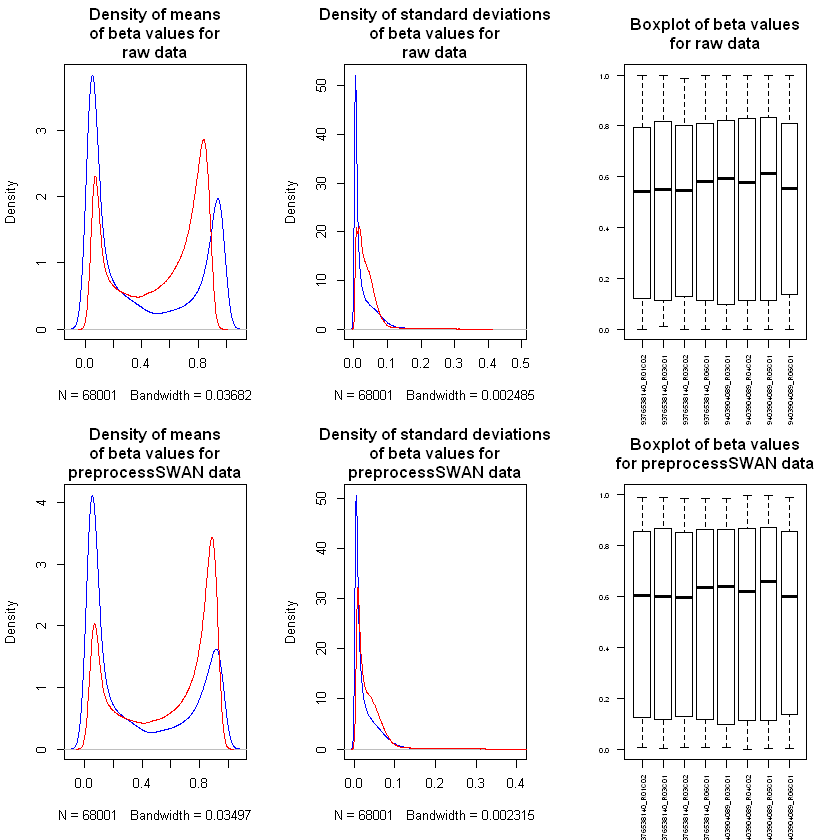

In [15]:
beta_I <- beta[rownames(beta) %in% dfI$IlmnID,]
beta_II <- beta[rownames(beta) %in% dfII$IlmnID,]

mean_of_beta_I <- apply(beta_I,1,mean)
mean_of_beta_II <- apply(beta_II,1,mean)
d_mean_of_beta_I <- density(mean_of_beta_I,na.rm=T)
d_mean_of_beta_II <- density(mean_of_beta_II,na.rm=T)

sd_of_beta_I <- apply(beta_I,1,sd)
sd_of_beta_II <- apply(beta_II,1,sd)
d_sd_of_beta_I <- density(sd_of_beta_I,na.rm=T)
d_sd_of_beta_II <- density(sd_of_beta_II,na.rm=T)

beta_preprocessSWAN_I <- beta_preprocessSWAN[rownames(beta_preprocessSWAN) %in% dfI$IlmnID,]
beta_preprocessSWAN_II <- beta_preprocessSWAN[rownames(beta_preprocessSWAN) %in% dfII$IlmnID,]

mean_of_beta_preprocessSWAN_I <- apply(beta_preprocessSWAN_I,1,mean)
mean_of_beta_preprocessSWAN_II <- apply(beta_preprocessSWAN_II,1,mean)
d_mean_of_beta_preprocessSWAN_I <- density(mean_of_beta_preprocessSWAN_I,na.rm=T)
d_mean_of_beta_preprocessSWAN_II <- density(mean_of_beta_preprocessSWAN_II,na.rm=T)

sd_of_beta_preprocessSWAN_I <- apply(beta_preprocessSWAN_I,1,sd)
sd_of_beta_preprocessSWAN_II <- apply(beta_preprocessSWAN_II,1,sd)
d_sd_of_beta_preprocessSWAN_I <- density(sd_of_beta_preprocessSWAN_I,na.rm=T)
d_sd_of_beta_preprocessSWAN_II <- density(sd_of_beta_preprocessSWAN_II,na.rm=T)

par(mfrow=c(2,3))
plot(d_mean_of_beta_I,col="blue",main="Density of means\nof beta values for\nraw data")
lines(d_mean_of_beta_II,col="red")
plot(d_sd_of_beta_I,col="blue",main="Density of standard deviations\nof beta values for\nraw data")
lines(d_sd_of_beta_II,col="red")
boxplot(beta,las=2,cex.axis=0.5,main="Boxplot of beta values\nfor raw data")
plot(d_mean_of_beta_preprocessSWAN_I,col="blue",main="Density of means\nof beta values for\npreprocessSWAN data")
lines(d_mean_of_beta_preprocessSWAN_II,col="red")
plot(d_sd_of_beta_preprocessSWAN_I,col="blue",main="Density of standard deviations\nof beta values for\npreprocessSWAN data")
lines(d_sd_of_beta_preprocessSWAN_II,col="red")
boxplot(beta_preprocessSWAN,las=2,cex.axis=0.5,main="Boxplot of beta values\nfor preprocessSWAN data")

## 4. Batch effects

Principal component analysis (PCA) is a dimension-reduction technique that minimizes dimensions while preserving covariance of the data. We perform the PCA on the functionally normalized beta values in order to check for batch effects (technical sources of variation that have been added to the samples due to experimental conditions and are unrelated to the biological variables in the study). The plot shows no clear separation between samples of the same slide or of the same array so no evident batch effects are observed.

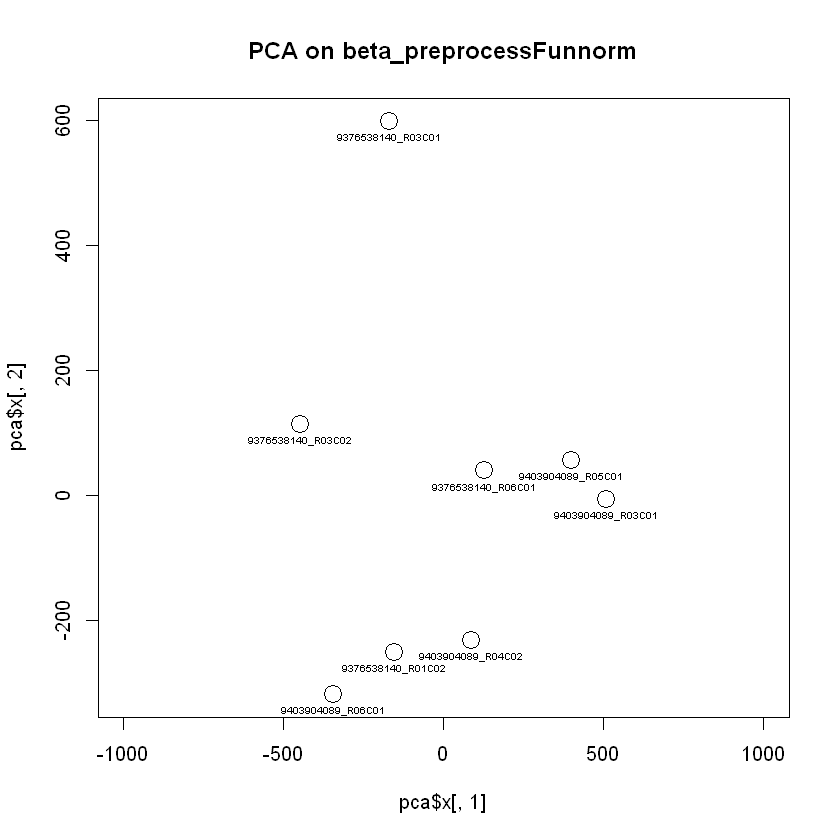

In [16]:
pca <- prcomp(t(beta_preprocessFunnorm),scale=T)

plot(pca$x[,1], pca$x[,2], xlim=c(-1000,1000),cex=2, main="PCA on beta_preprocessFunnorm")
text(pca$x[,1], pca$x[,2],labels=rownames(pca$x),cex=0.5,pos=1)

## 5. Differential methylation

### 5.1. ANOVA test correcting for body mass index (BMI)
In order to identify differentially methylated probes between group A and group B, a statistical test, for example, **ANOVA test correcting for body mass index (BMI)**, is performed. First, we load the sample sheet that contains phenotypical information. Next, an ad hoc function is implemented which performs the ANOVA test using BMI as a covariate and returns the p-value from the summary of the ANOVA test. We apply the function to the normalized SWAN beta values and obtain the p-values. A data frame is created from the SWAN normalized beta values and the calculated p-values which is then sorted based on the latter.

In [17]:
pheno <- read.csv("SampleSheet_report.csv",sep=",")

MYanovaFunction <- function(x) {
	anova_test <- aov(x ~ pheno$Group+pheno$BMI)
	return(summary(anova_test)[[1]][[5]][1])
}

pValuesAnova <- apply(beta_preprocessSWAN,1,MYanovaFunction)
final_Anova <- data.frame(beta_preprocessSWAN,pValuesAnova)
final_Anova <- final_Anova[order(final_Anova$pValuesAnova),]

### 5.2. Multiple test correction
We apply a multiple test correction procedure to adjust our statistical confidence measures based on the number of tests performed. In the case of Bonferroni correction the nominal p-values are multiplied by the number of tests (probes), while in the case of Benjamini and Hochberg (BH) correction the nominal p-values are ranked, multiplied by the number of tests (probes) and divided by the their rank. We use the significance threshold of 0.05 and obtain the number of differentially methylated probes considering the three p-values, respectively. The results are visible in the table below.

In [18]:
raw_pValues <- final_Anova$pValuesAnova
corrected_pValues_Bonf <- p.adjust(raw_pValues,"bonferroni")
corrected_pValues_BH <- p.adjust(raw_pValues,"BH")
final_Anova_corrected <- data.frame(final_Anova,corrected_pValues_Bonf,corrected_pValues_BH)

DMP <- t(data.frame(dim(final_Anova_corrected[final_Anova_corrected$pValuesAnova<=threshold,])[1],
                    dim(final_Anova_corrected[final_Anova_corrected$corrected_pValues_BH<=threshold,])[1],
                    dim(final_Anova_corrected[final_Anova_corrected$corrected_pValues_Bonf<=threshold,])[1]))
colnames(DMP) <- paste("number of DMPs (p-value<",threshold,")",sep='')
rownames(DMP) <- c("nominal p-values","Bonferroni corrected p-values","BH corrected p-values")
DMP

,number of DMPs (p-value<0.05)
nominal p-values,54975
Bonferroni corrected p-values,4
BH corrected p-values,0


### 5.3. Volcano plot
Volcano plot is a type of scatter-plot which combines a measure of statistical significance (negative logarithm of p-value) with the magnitude of the change (on the y and x axis, respectively), enabling quick visual identification of those data-points that display large magnitude changes that are also statistically significant. Using the significance threshold of 0.05 (green dashed line), we obtain hypomethylated probes depicted in blue and hypermethylated probes depicted in red.

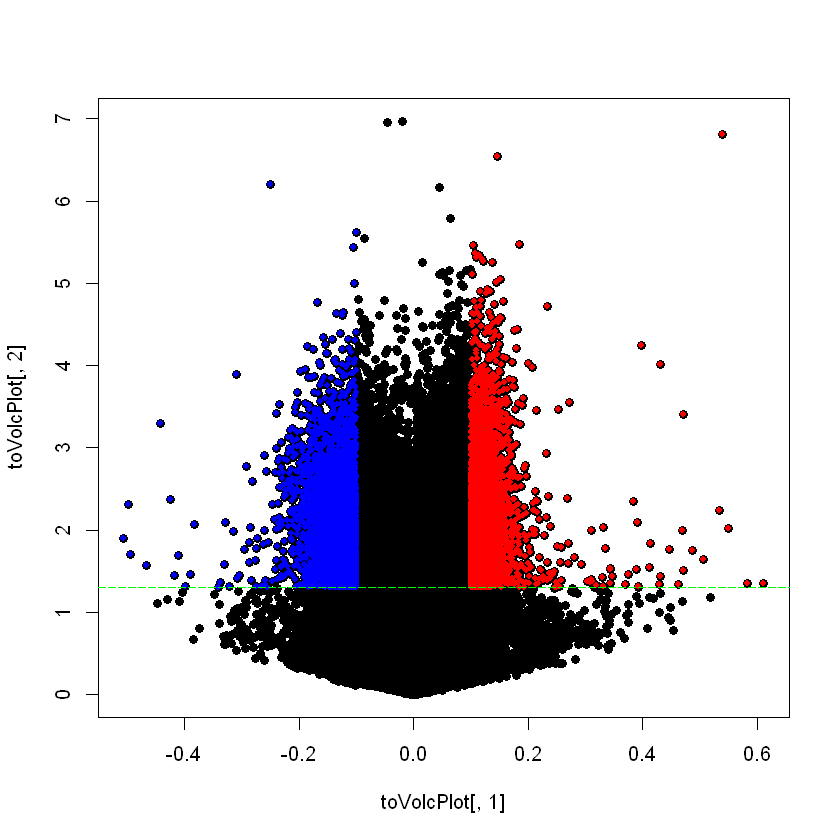

In [19]:
beta <- final_Anova_corrected[,1:8]
beta_groupA <- beta[,pheno$Group=="A"]
mean_beta_groupA <- apply(beta_groupA,1,mean)
beta_groupB <- beta[,pheno$Group=="B"]
mean_beta_groupB <- apply(beta_groupB,1,mean)
delta <- mean_beta_groupB-mean_beta_groupA

toVolcPlot <- data.frame(delta, -log10(final_Anova_corrected$pValuesAnova))
plot(toVolcPlot[,1], toVolcPlot[,2],pch=16)
toHighlight <- toVolcPlot[-toVolcPlot[,1]>0.1 & toVolcPlot[,2]>(-log10(threshold)),]
points(toHighlight[,1], toHighlight[,2],pch=16,cex=0.7,col="blue")
toHighlight <- toVolcPlot[toVolcPlot[,1]>0.1 & toVolcPlot[,2]>(-log10(threshold)),]
points(toHighlight[,1], toHighlight[,2],pch=16,cex=0.7,col="red")
abline(a=-log10(threshold),b=0,col="green",lty="longdash")

### 5.4. Manhattan plot
Manhattan plot is another type of scatter plot, usually used to display data with a large number of data-points. Chromosomes are displayed on the x axis, with a measure of statistical significance (negative logarithm of p-value) displayed on the y axis. The black horizontal line indicates the significance threshold of 0.05.

Plotting points  1 - 23487 
Plotting points  23488 - 41290 
Plotting points  41291 - 53812 
Plotting points  53813 - 64484 
Plotting points  64485 - 76819 
Plotting points  76820 - 95208 
Plotting points  95209 - 110131 
Plotting points  110132 - 120620 
Plotting points  120621 - 125488 
Plotting points  125489 - 137611 
Plotting points  137612 - 151928 
Plotting points  151929 - 164149 
Plotting points  164150 - 170546 
Plotting points  170547 - 177932 
Plotting points  177933 - 185609 
Plotting points  185610 - 196590 
Plotting points  196591 - 210441 
Plotting points  210442 - 213273 
Plotting points  213274 - 225972 
Plotting points  225973 - 231161 
Plotting points  231162 - 233271 
Plotting points  233272 - 237547 
Plotting points  237548 - 243120 
Plotting points  243121 - 243329 


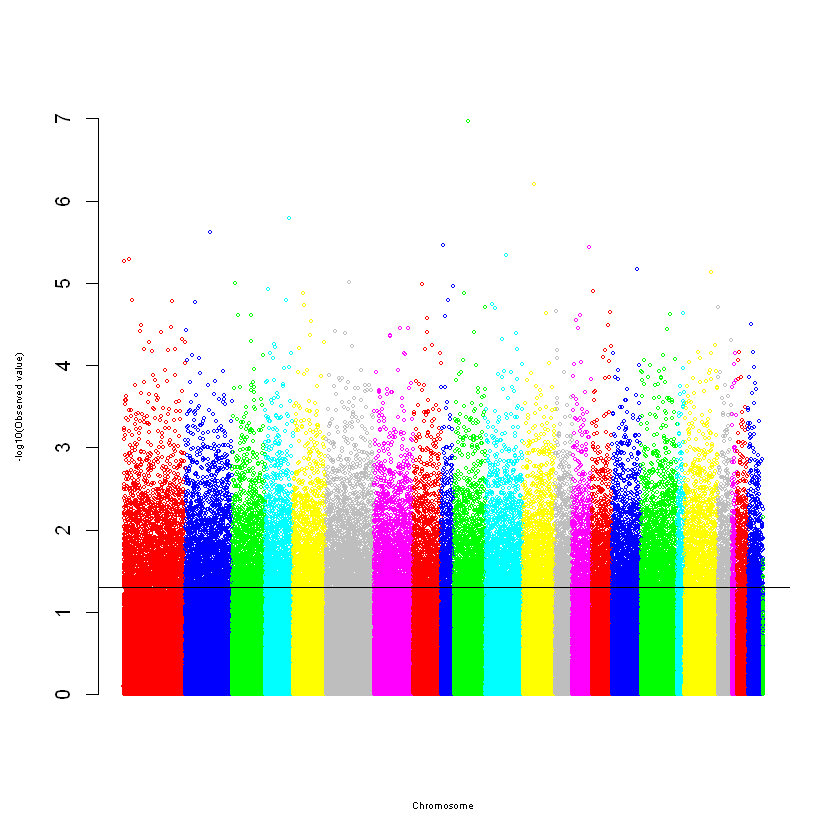

In [20]:
load('final_Anova_corrected.RData')
final_Anova_corrected <- data.frame(rownames(final_Anova_corrected),final_Anova_corrected)
colnames(final_Anova_corrected)[1] <- "IlmnID"
final_Anova_corrected_annotated <- merge(final_Anova_corrected, Illumina450Manifest_clean,by="IlmnID")

db <- data.frame(final_Anova_corrected_annotated$CHR, 
                 final_Anova_corrected_annotated$MAPINFO, 
                 final_Anova_corrected_annotated$pValuesAnova)
db$final_Anova_corrected_annotated.CHR <- factor(db$final_Anova_corrected_annotated.CHR,
                                                 levels=c(paste(c(1:22)),'X','Y'))

palette <- rep(c("red","blue","green","cyan","yellow","gray","magenta"),4)[1:24]
mhtplot(db,control=mht.control(colors=palette))
axis(2,cex=0.5)
abline(a=-log10(threshold),b=0)

### 5.5. Multidimensional scaling (MDS) plot
Multidimensional scaling (MDS) is dimension-reduction technique that minimizes dimensions while preserving distance between data points. It takes a set of dissimilarities (euclidean distances in our case) and returns a set of points such that the distances between the points are approximately equal to the dissimilarities. The MDS plot on probes selected as differentially methylated on the basis of nominal p-values (significance threshold of 0.05) clearly separates the two groups (A and B) along the x axis. However, one outlier belonging to the group A can be observed in the upper right part of the plot.

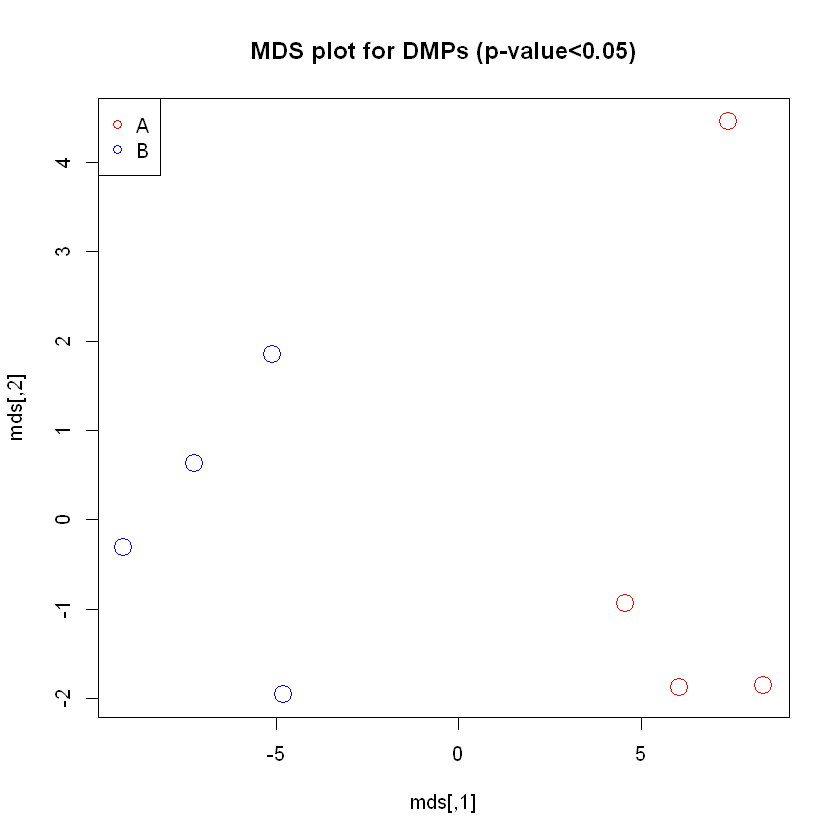

In [21]:
final_Anova_corrected_annotated_sign <- final_Anova_corrected_annotated[final_Anova_corrected_annotated$pValuesAnova<threshold,]
final_Anova_corrected_annotated_sign <- droplevels(final_Anova_corrected_annotated_sign)

dist.euc=dist(t(final_Anova_corrected_annotated_sign[,2:9]))
mds=cmdscale(dist.euc)

plot(mds,type="n",main=paste("MDS plot for DMPs (p-value<",threshold,")",sep=''))
points(mds[pheno$Group=="A",],col="red",cex=2)
points(mds[pheno$Group=="B",],col="blue",cex=2)
legend("topleft",c("A","B"),pch=1,col=c("red","blue"))